# **Importação das Livrarias**

Vamos importar todas as livrias necessárias para construção do modelo.

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
import os
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# **Pré-Processamento de dados.**

Aqui, em primeiro lugar, iremos construir o DataFrame contendo as imagens e as categorias a que eles pertencem.

Também é possível construir diretamente através do ImageDataGenerator, atribuindo o argumento validation_split, como consta na [documentação](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Porém, por algum motivo, esse método me trazia desempenhos menores, então decidi partir do DataFrame.

In [22]:
diretorios = os.listdir("../input/animals10/raw-img/")

imagens_l, labels_l = [], []

for diretorio in diretorios:
    for imagem in os.listdir("../input/animals10/raw-img/"+diretorio):
        imagens_l.append("../input/animals10/raw-img/"+diretorio+"/"+imagem)
        labels_l.append(diretorio)
else:
    # Ao fim do loop cria-se um dataframe com o caminho e a categoria.
    df = pd.DataFrame({
        "caminho":imagens_l,
        "categoria":labels_l
    })

df.head()

Aqui nós dividimos o DataFrame em treino e teste, na razão 20% para teste. 

Por algum motivo, ao tentar mover a razão para 10% para teste, o modelo não fazia a validação lá embaixo.

Veja a documentação do [TrainTestSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para mais informações.

In [23]:
df_treino, df_teste = train_test_split(df, test_size = 0.2)
df_treino.head()

,caminho,categoria
7111,../input/animals10/raw-img/gatto/ea37b90821fd0...,gatto
16477,../input/animals10/raw-img/ragno/OIP-SDyO6sifa...,ragno
20746,../input/animals10/raw-img/cane/OIP-vgkDI030hL...,cane
14452,../input/animals10/raw-img/ragno/OIP-p3clBiD6p...,ragno
1233,../input/animals10/raw-img/cavallo/OIP-TDRXvol...,cavallo


Nós iremos agora ao Data Augmentation.

Criamos um gerador para o treino e para o teste, separadamente, e precisamos apenas atribuir os argumetnos ao de treino.

Essa etapa, caso você não opte por fazer o DataFrame feito anteriormente, você terá que atribuir um argumento validation_split no ImageDataGenerator, e depois os argumentos subsets para as variáveis. Veja a documentação.

Não é necessário, **para o EfficientNetB7**, inserir a normalização dos dados, ela já é parte do modelo propriamente dito (através de uma camada Rescaling). Caso seja outro modelo, talvez você seja obrigado a aplicar algum tipo de pré-processamento de imagens (como o VGG16)
> For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer), and thus tf.keras.applications.efficientnet.preprocess_input is actually a pass-through function

Fonte: [Documentação do Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB7)

In [157]:
BATCH_SIZE = 64
w = 224
h = 224

gerador_treino = ImageDataGenerator(rotation_range = 30,
                                   width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

gerador_teste = ImageDataGenerator()

xtreino = gerador_treino.flow_from_dataframe(dataframe = df_treino,
                                            x_col = "caminho",
                                            y_col = "categoria",
                                            target_size = (w, h),
                                            batch_size = BATCH_SIZE)
                                             
xteste = gerador_teste.flow_from_dataframe(dataframe = df_teste,
                                            x_col = "caminho",
                                            y_col = "categoria",
                                            target_size = (w, h),
                                            batch_size = BATCH_SIZE)

Found 20943 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


Nós só iremos dar uma olhada nas classes criadas pelo ImageDataGenerator.

In [25]:
xtreino.class_indices

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

Antes de prosseguir com a construção do modelo, iremos dar uma visualização básica em alguma imagem, escolhida aleatoriamente.

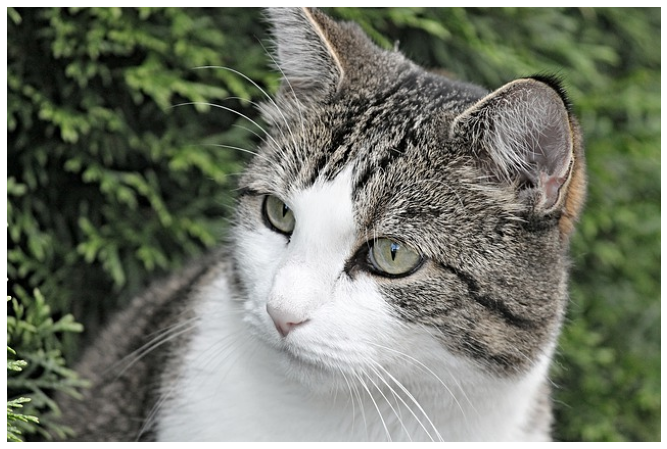

In [26]:
lista_imagens = glob.glob("../input/animals10/raw-img/*/*.jpg")
imagem_aleatoria = np.random.choice(lista_imagens)

imagem = cv2.imread(imagem_aleatoria)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,8))
plt.imshow(imagem)
plt.axis('off')
plt.show()

# **Construção do Modelo**

Para esse modelo, é importantíssimo você incluir o argumento *include_top* como **False**, pois, caso contrário, as últimas 3 camadas fully-connected serão incluídas no topo da rede, o que não queremos.

Além disso, eu não quis que o modelo fosse treinável, sendo assim, fiz com que camada dele não fosse treinada.

**QUANTO AO OTIMIZADOR (WHICH OPTIMIZER USE? // ADAM vs SGD)**

Esta é a pergunta de 1 milhão de dólares.

Vi muitos notebooks usando SGD, e alguns outros usando Adam, e decidi fazer na força bruta.

**Obtive melhores resultados usando SGD**, o modelo demorou umas 5 epochs para convergir acima dos 90%.

Em geral, segundo este [artigo](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/), SGD (com/with momentum) tende a generalizar melhor (ou substancialmente melhor) que o Adam, enquanto este converge mais rápido.

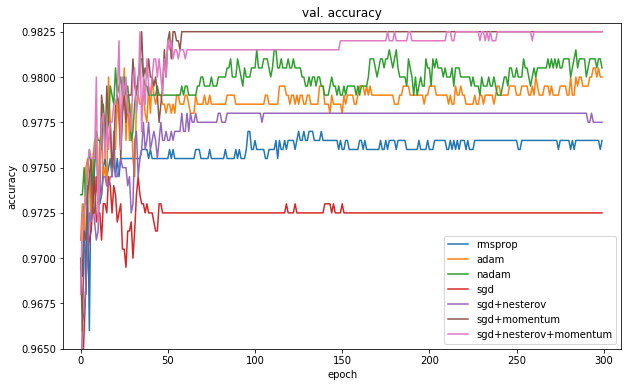!

**Qual learning_rate/momentum usar? (How much learning_rate/momentum value?)**

Apenas por força bruta você saberá, mas é possível saber bons valores de partida:

**learning_rate:** começar usando 1e-2 e ir diminuindo a partir daí para 5e-3, 1e-3, 5e-4, 1e-4, etc... foi uma boa estratégia para mim, até eu chegar em um valor ótimo.

**momentum:** começar com 0.9, e, depois de achar um learning_rate bom, testar com 0.99 ou 0.5, e ir ajustando a partir daí até chegar em um valor bom.

**Outras estratégias:**

Você pode utilizar [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/), eu não cheguei a utilizar, achei que os resultados já eram bons.

Além disso, você pode adicionar mais camadas ocultas no modelo, vi notebooks começando com 256 e partindo pra potências de 2 (128, 512, 1024), com funções de ativação "relu" e adicionando uma camada de Dropout logo em seguida. Cheguei a testar modelos assim, mas eles tendiam a diminuir minha acurácia.

Para mais informações, veja esse [post](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/).

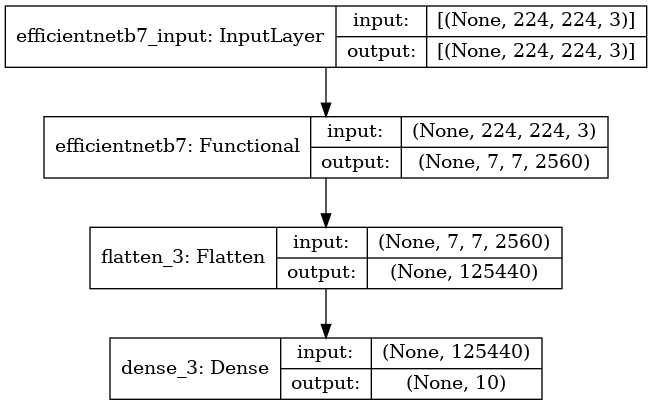

In [27]:
vgg16 = EfficientNetB7(include_top = False,
             input_shape = (w, h, 3),
             weights = "imagenet")

for layer in vgg16.layers:
    layer.trainable = False

modelo = Sequential()

modelo.add(vgg16)
modelo.add(Flatten())
modelo.add(Dense(10, activation = "softmax"))

otimizador = SGD(learning_rate = 3e-3, momentum = 0.6)

modelo.compile(loss="categorical_crossentropy",
              optimizer = otimizador,
              metrics = ["accuracy"])

plot_model(modelo, show_shapes = True)

# **Treinamento do modelo**

Em geral, como o SGD tende a convergir mais devagar, você poderá utilizar mais épocas para ele convergir melhor e testar melhor seus resultados.

Eu tinha adicionado um [ModelCheckPoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) para salvar o modelo no melhor momento da validação, mas, como ele demorava ligeiramente mais para realizar os treinamentos, decidir retirar. Fica a seu critério adicionar.

Eu adicionei *validation_steps* e *steps_per_epoch* para adiantar o treinamento, torná-lo mais rápido. Para mais informações acerca do funcionamento dos dois argumentos, veja essa [resposta](https://stackoverflow.com/a/45944225) no StackOverflow.

In [28]:
cbs = [
    ModelCheckpoint(filepath = "modelo.h5",
                   monitor = "val_loss",
                   save_best_only = True,
                   save_weights_only=True)
]

history = modelo.fit(xtreino,
                    epochs = 50,
                    validation_data = xteste,
                    validation_steps = len(xteste) // BATCH_SIZE,
                    steps_per_epoch = len(xtreino) // BATCH_SIZE)

Epoch 1/50
5/5 [==============================] - 57s 3s/step - loss: 2.6242 - accuracy: 0.3656 - val_loss: 1.7502 - val_accuracy: 0.7812
Epoch 2/50
5/5 [==============================] - 7s 1s/step - loss: 1.3361 - accuracy: 0.7969 - val_loss: 0.4790 - val_accuracy: 0.8750
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.5490 - accuracy: 0.8594 - val_loss: 0.3881 - val_accuracy: 0.9219
Epoch 4/50
5/5 [==============================] - 7s 1s/step - loss: 0.3200 - accuracy: 0.9031 - val_loss: 0.3060 - val_accuracy: 0.9219
Epoch 5/50
5/5 [==============================] - 7s 1s/step - loss: 0.2195 - accuracy: 0.9312 - val_loss: 0.2719 - val_accuracy: 0.9375
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.2304 - accuracy: 0.9375 - val_loss: 0.1803 - val_accuracy: 0.9531
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.2878 - accuracy: 0.9281 - val_loss: 0.1323 - val_accuracy: 0.9688
Epoch 8/50
5/5 [========================

# **Visualização dos resultados**

Primeiro, vamos olhar o loss e acurácia.

O loss oscila pouco, eu cheguei à conclusão que poderia aumentar o learning_rate baseado nesse princípio, mas, como já alcancei um resultado que desejava, fiquei por aqui.

Veja que o modelo alcançou uma acurácia boa logo de início.

Text(0, 0.5, 'Accuracy')

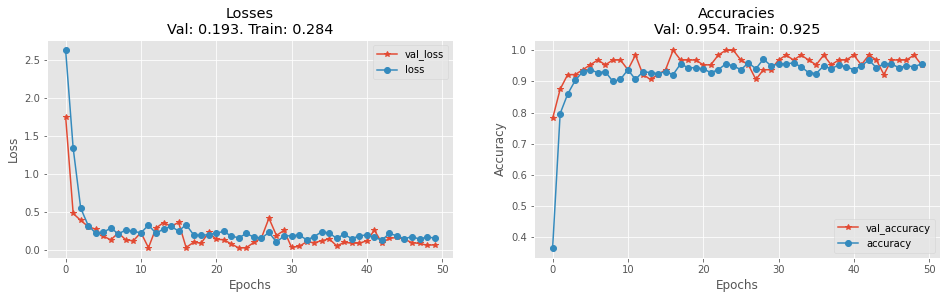

In [29]:
val_acc = np.mean(history.history['val_accuracy'])
val_loss = np.mean(history.history['val_loss'])
acc = np.mean(history.history['accuracy'])
loss = np.mean(history.history['loss'])

plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['val_loss'], marker='*')
plt.plot(history.history['loss'], marker = 'o')
plt.legend(["val_loss", "loss"])
plt.title(f"Losses\nVal: {val_loss:.3f}. Train: {loss:.3f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], marker='*')
plt.plot(history.history['accuracy'], marker='o')
plt.legend(["val_accuracy", "accuracy"])
plt.title(f"Accuracies\nVal: {val_acc:.3f}. Train: {acc:.3f}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Vamos ver a perfomance do modelo em relação à base de teste.

In [156]:
perfomance = modelo.evaluate(xteste)
print()
print(f"Loss médio: {perfomance[0]:.4f}")
print(f"Acurácia média: {perfomance[1]*100:.2f}%")

82/82 [==============================] - 35s 423ms/step - loss: 0.1280 - accuracy: 0.9637

Loss médio: 0.1280
Acurácia média: 96.37%


Vamos agora ver a ConfusionMatrix do nosso modelo

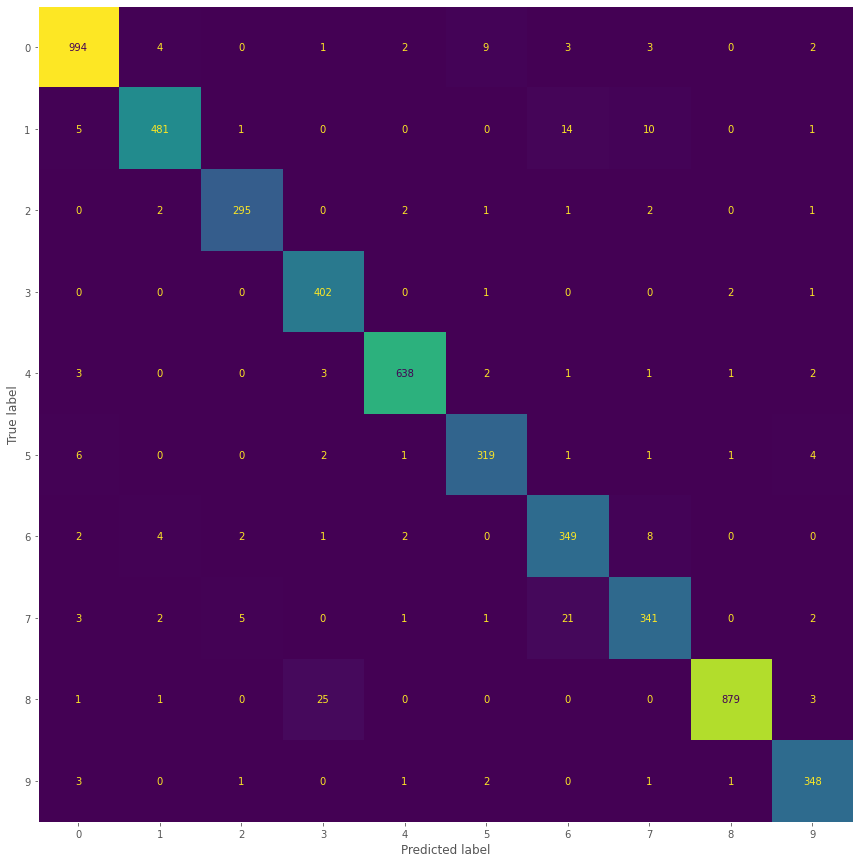

In [154]:
predicoes = modelo.predict(xteste, verbose = 1)
y_pred = np.argmax(predicoes, axis=1)
y_true = np.array(xteste.classes)

cm = confusion_matrix(y_true, y_pred)


fig, ax = plt.subplots(figsize=(13,13))
ax.grid(False)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

disp.plot(ax=ax,
         colorbar = False)

# **Prevendo algumas imagens**

Eu vou prever uma imagem para cada classe possível.

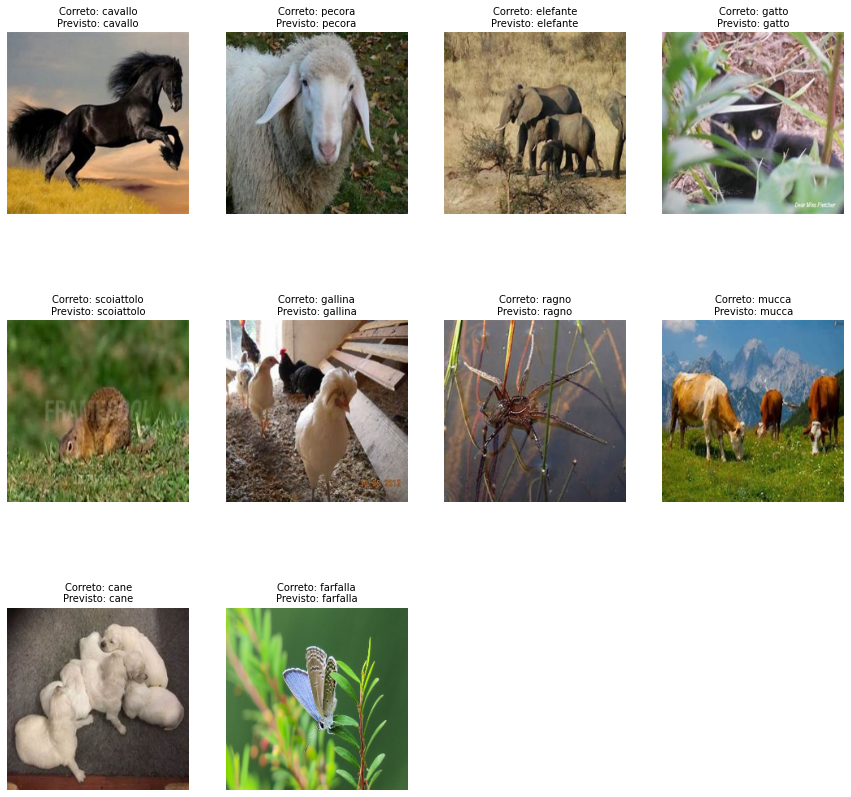

In [62]:
plt.figure(figsize=(15,15))
for i, diretorio in enumerate(os.listdir("../input/animals10/raw-img")):
    imagens_totais = os.listdir("../input/animals10/raw-img/"+diretorio)
    imagem_aleatoria = "../input/animals10/raw-img/"+diretorio+"/"+np.random.choice(imagens_totais)
    
    imagem = cv2.imread(imagem_aleatoria)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (w, h))
    
    img = np.expand_dims(imagem, axis = 0)
    
    indice = np.argmax(modelo.predict(img))
    previsao = list(xtreino.class_indices.keys())[indice]
    
    plt.subplot(3,4,i+1)
    plt.imshow(imagem)
    plt.axis('off')
    plt.title(f"Correto: {diretorio}\nPrevisto: {previsao}", fontsize=10)

